## RTK + GG Visualization
#### April Novak

This notebook illustrates how to visualize a combined RTK (in-core) and GG (ex-core) geometry. This notebook is held on `orthanc`, but is launched through the Mounts, so my personal machine has to have the `casl2omni` branch checked out so that my machine knows about those updates. To do this, from `~/projects/Exnihilo`, do `git fetch; git checkout -t origin/casl2omni`. Then, build in the build directory on my personal machine (`~/Builds/Exnihilo`) by doing `make install`. Then, because this notebook is being launched from a Mount, the file path in the `ex-core.gg.xml` file that is to be read in must be edited so that the correct path (_through the Mount_) is read.


In [1]:
import sys

import h5py as h5
import numpy as np
import matplotlib.pyplot as plt

# path to Exnihilo-specific python modules on your machine. This is a path
# on a personal machine due to the mounting to orthanc.
sys.path.insert(0, '/Users/aprilnovak/Installs/python')

import exnihilotools.matplotlib as extools

extools.screen_style()
%matplotlib inline

In [2]:
# for plotting tallies
from omnibus.data import plot
from matplotlib.colors import Normalize, LogNorm

In [3]:
# This shows where this notebook is importing geometria from
import geometria
geometria.__file__

'/Users/aprilnovak/Installs/python/geometria.py'

In [4]:
# for plotting geometry
from geometria import GG_Geometry
from omnibus.raytrace.colors import ColorMap
from omnibus.raytrace.imager import Imager
from omnibus.raytrace.load import load_gg

In [5]:
xml_path = '/Users/aprilnovak/Mounts/orthanc/projects/nkq_analysis/vera-inputs/'
# Because this is launched through the Mount, you have to manually edit the file path within 
# the XML file so that it is reading from the Mount. So, use XML files with extension
# notebook.gg.xml
filename = '4x4-excore/4x4-excore-notebook.gg.xml'
comp_filename = '4x4-excore/4x4-excore.shift_compositions-custom.h5'

model = load_gg(xml_path + filename)

In [6]:
# try to make all the colors the same
from omnibus.formats.comp import load as load_comps
from omnibus.raytrace.colors import Composition

comps = load_comps(xml_path + comp_filename)
comps = [Composition(**d) for d in comps['compositions'].tolist()]


Loading HDF5 file...
Loading Compositions from HDF5 data at /Users/aprilnovak/Mounts/orthanc/projects/nkq_analysis/vera-inputs/4x4-excore/4x4-excore.shift_compositions-custom.h5
INFO: Loaded 'UNKNOWN': Compositions calculated on 2017JAN18 15:41
INFO: Data generated with Exnihilo version b'6.2 (r29396: #b538b683 on 2017JAN05) [DBC=7]', Scale version b'6.3 (r22322: #12f94e8b on 2017JAN10) [DBC=7]'
            ...finished loading HDF5 file
/Users/aprilnovak/Installs/python/omnibus/data/dataset.py:146: RuntimeWarning: Extracting compound dataset manually because this version of h5py does not properly support aligned data types
  "data types", RuntimeWarning)


In [7]:
colors = ColorMap.from_compositions(comps)

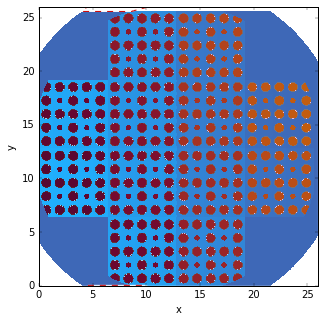

In [8]:
z = 0.5
x = 4*6.5
y = 4*6.5

# plot using a method where you can specify the lower left corner and the 
# upper right corner of the desired domain
imager = Imager(model.geometry, lower = (0.0, 0.0, z), upper = (x, y, z), \
                basis = (1, 0, 0), max_pixels=1200)
imager.set_colors(colors)
imager.check_errors = True
imager.plot(figsize=(5.0, 5.0));


## Model with only a baffle, but no vessel

The GG to XML writer only converts the fuel - no baffle is retained. For this example, a custom material is defined as a mixture of water and fuel ("waterfuel") and is used in the core barrel. 

In [9]:
model = load_gg(xml_path + 'baffle/baffle-notebook.gg.xml')
comps = load_comps(xml_path + 'baffle/baffle.shift_compositions-custom.h5')
comps = [Composition(**d) for d in comps['compositions'].tolist()]
colors = ColorMap.from_compositions(comps)

Loading HDF5 file...
Loading Compositions from HDF5 data at /Users/aprilnovak/Mounts/orthanc/projects/nkq_analysis/vera-inputs/baffle/baffle.shift_compositions-custom.h5
INFO: Loaded 'UNKNOWN': Compositions calculated on 2017JAN19 08:52
INFO: Data generated with Exnihilo version b'6.2 (r29396: #b538b683 on 2017JAN05) [DBC=7]', Scale version b'6.3 (r22322: #12f94e8b on 2017JAN10) [DBC=7]'
            ...finished loading HDF5 file
/Users/aprilnovak/Installs/python/omnibus/data/dataset.py:146: RuntimeWarning: Extracting compound dataset manually because this version of h5py does not properly support aligned data types
  "data types", RuntimeWarning)


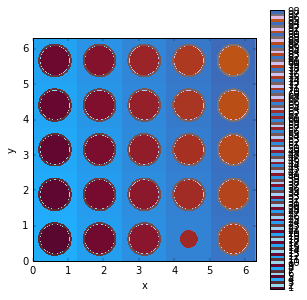

In [10]:
z = 0.5
x = 6.3
y = 6.3

imager = Imager(model.geometry, lower = (0.0, 0.0, z), upper = (x, y, z), \
                basis = (1, 0, 0), max_pixels=1200)
imager.set_colors(colors)
imager.check_errors = True
imager.plot(figsize=(5.0, 5.0));

{'ax': <matplotlib.axes._subplots.AxesSubplot at 0x1125bdf28>,
 'ax2': <matplotlib.axes._axes.Axes at 0x114a1e940>,
 'cbar': <matplotlib.colorbar.Colorbar at 0x114a166a0>,
 'fig': <matplotlib.figure.Figure at 0x113cf7c18>,
 'plot': <matplotlib.image.AxesImage at 0x11489da20>}

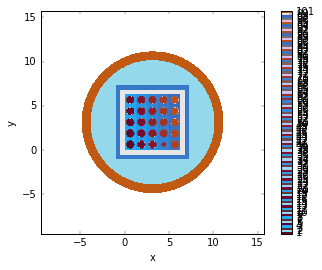

In [11]:
imager.scale(0.25)
imager.plot()

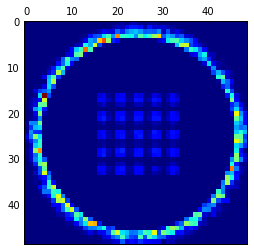

In [12]:
with h5.File("/Users/aprilnovak/Mounts/orthanc/projects/nkq_analysis/vera-inputs/baffle/baffle.out.h5", 'r') as f:    
    mesh_tal = f['tally']['mesh_tally']
    mesh_total = mesh_tal['total']
    points = len(mesh_total[0])
    mesh_matrix = np.empty((points, points))
    
    for i in range(points):
        for j in range(points):
            # correct orientation of the data
            mesh_matrix[i][j] = mesh_total[0][-i][j][0][0]
    
    plt.matshow(mesh_matrix)